In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
import sys
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

from models.Backbone import ResnetBackBone
from utils.Utility import Args, encodeAge, setSeedEverything, calcF1Score, load_model

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args = Args(
    root_path={'train': './data/train/images/', 'test': './data/eval/images/'},
    random_seed=999,
    csv_path={'train':'./data/train_i.csv', 'test': './data/eval_i.csv'},
    batch_size=64,
    lr=0.001,
    device=device,
    img_size=224,
    epochs=10,
    save_dir='./models/ckpt'
)

In [3]:
df = pd.read_csv(args.csv_path['train'])

train_df, val_df, _, _ = train_test_split(df, df.age.values, test_size=0.1, random_state=args.random_seed)
train_df.sample(5)

,id,gender,age,mask,path,gender_class,age_class,mask_class
12560,1794,male,56,Incorrect,./data/train/images/004250_male_Asian_56/incor...,0,1,1
8485,1212,female,20,Wear,./data/train/images/003175_female_Asian_20/mas...,1,0,0
9157,1308,female,20,Wear,./data/train/images/003326_female_Asian_20/mas...,1,0,0
4579,654,female,54,Wear,./data/train/images/001338_female_Asian_54/mas...,1,1,0
16108,2301,male,19,NotWear,./data/train/images/006136_male_Asian_19/norma...,0,0,2


In [4]:
class CustomDataset(Dataset):
    def __init__(
        self,
        root_path,
        img_paths,
        labels,
        transform=None,
        train=True
        ):
        self.root_path = root_path
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        
        if self.transform is not None:
            img = self.transform(image=img, width=w, height=h, depth=c)['image']

        if self.labels is not None:
            label = self.labels[index]
            return {'image' : img, 'height' : h, 'width' : w, 'channel' : c, 'label' : label}
        else:
            return {'image' : img, 'height' : h, 'width' : w, 'channel' : c}

In [5]:
# transform 제작
transform = A.Compose([
    A.Resize(args.img_size, args.img_size),
    A.Normalize((0.560, 0.524, 0.501), (0.098, 0.096, 0.097)),
    ToTensorV2()
])

In [6]:
train_dataset = CustomDataset(args.root_path['train'], train_df.path.values, train_df.age_class.values, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)

val_dataset = CustomDataset(args.root_path['train'], val_df.path.values, val_df.age_class.values, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [7]:
model = ResnetBackBone().to(args.device)
loss_func = nn.CrossEntropyLoss().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = None

In [8]:
best_val_acc = 0
best_val_loss = np.inf
best_model = None

train_loss_items = []
train_acc_items = []
val_loss_items = []
val_acc_items = []

for epoch in range(1, args.epochs+1):
    model.train()
    for data in tqdm(train_loader):
        inputs = data['image'].to(args.device)
        labels = data['label'].to(args.device)

        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        train_loss = loss_func(outs, labels)

        train_loss.backward()
        optimizer.step()

        train_loss_items.append(train_loss.item())
        train_acc = (preds == labels).sum().item() / len(preds)
        train_acc_items.append(train_acc)

    with torch.no_grad():
        for val_data in val_loader:
            inputs, labels = val_data['image'], val_data['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)
            f1_score = calcF1Score(preds.detach().cpu(), labels.detach().cpu())

            val_loss = loss_func(outs, labels).item()
            val_acc = (labels == preds).sum().item() / len(labels)
            val_loss_items.append(val_loss)
            val_acc_items.append(val_acc)

            best_val_loss = min(best_val_loss, val_loss)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                
            # torch.save(model.module.state_dict(), f"{save_dir}/last.pth")
    
    print(f'EPOCH: {epoch}/{args.epochs} | train loss: {train_loss:.3f}, train acc: {train_acc:.3f} | val loss: {val_loss:.3f}, val acc: {val_acc:.3f} f1_score: {f1_score:.3f}')

os.makedirs(f'{args.save_dir}', exist_ok=True)
torch.save(best_model.state_dict(), f"{args.save_dir}/{args.epochs}_best.pth")
    # wandb.log({
    #     "train_loss": train_loss,
    #     "train_acc": train_acc,
    #     "val_loss": val_loss,
    #     "val_acc": val_acc,
    # })

    # Optional
    # wandb.watch(model)

100%|██████████| 266/266 [00:58<00:00,  4.56it/s]


EPOCH: 1/10 | train loss: 0.034, train acc: 1.000 | val loss: 0.046, val acc: 1.000 f1_score: 1.000


100%|██████████| 266/266 [00:57<00:00,  4.63it/s]


EPOCH: 2/10 | train loss: 0.160, train acc: 0.960 | val loss: 0.063, val acc: 0.971 f1_score: 0.876


100%|██████████| 266/266 [00:57<00:00,  4.64it/s]


EPOCH: 3/10 | train loss: 0.040, train acc: 1.000 | val loss: 0.128, val acc: 0.941 f1_score: 0.806


100%|██████████| 266/266 [00:57<00:00,  4.59it/s]


EPOCH: 4/10 | train loss: 0.138, train acc: 0.920 | val loss: 0.040, val acc: 0.971 f1_score: 0.978


100%|██████████| 266/266 [00:58<00:00,  4.57it/s]


EPOCH: 5/10 | train loss: 0.017, train acc: 1.000 | val loss: 0.068, val acc: 0.971 f1_score: 0.919


100%|██████████| 266/266 [00:57<00:00,  4.60it/s]


EPOCH: 6/10 | train loss: 0.030, train acc: 0.980 | val loss: 0.015, val acc: 1.000 f1_score: 1.000


100%|██████████| 266/266 [00:57<00:00,  4.62it/s]


EPOCH: 7/10 | train loss: 0.022, train acc: 0.980 | val loss: 0.108, val acc: 0.971 f1_score: 0.919


100%|██████████| 266/266 [00:58<00:00,  4.57it/s]


EPOCH: 8/10 | train loss: 0.018, train acc: 1.000 | val loss: 0.017, val acc: 1.000 f1_score: 1.000


100%|██████████| 266/266 [00:58<00:00,  4.57it/s]


EPOCH: 9/10 | train loss: 0.066, train acc: 0.960 | val loss: 0.002, val acc: 1.000 f1_score: 1.000


100%|██████████| 266/266 [00:57<00:00,  4.60it/s]


EPOCH: 10/10 | train loss: 0.010, train acc: 1.000 | val loss: 0.113, val acc: 0.971 f1_score: 0.876


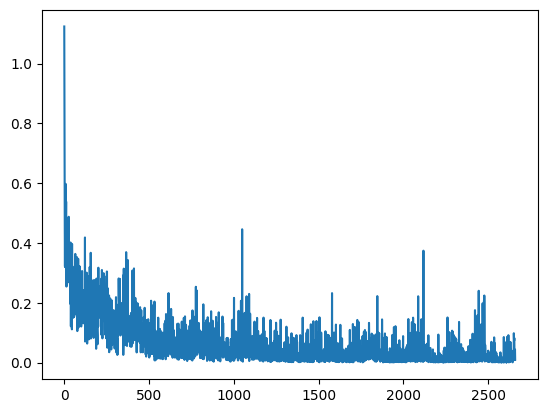

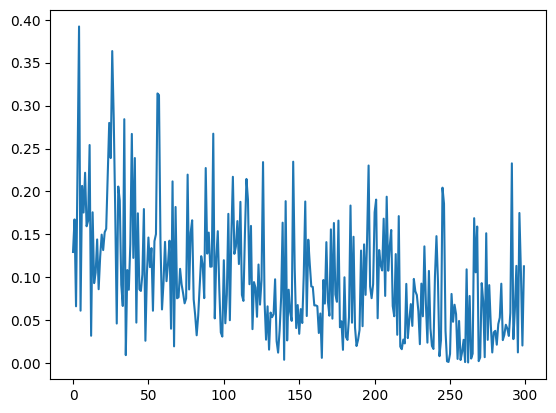

In [15]:
sns.lineplot(
    x=range(len(train_loss_items)),
    y=train_loss_items
)
plt.show()

sns.lineplot(
    x=range(len(val_loss_items)),
    y=val_loss_items
)
plt.show()

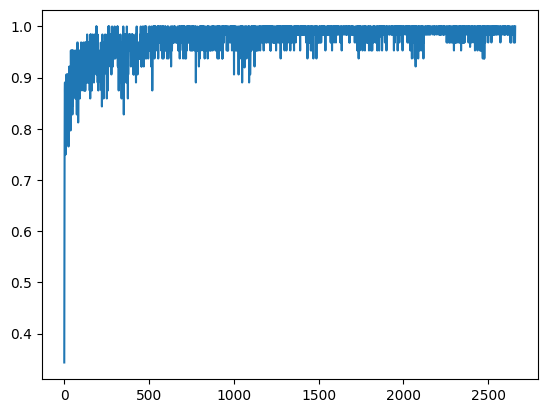

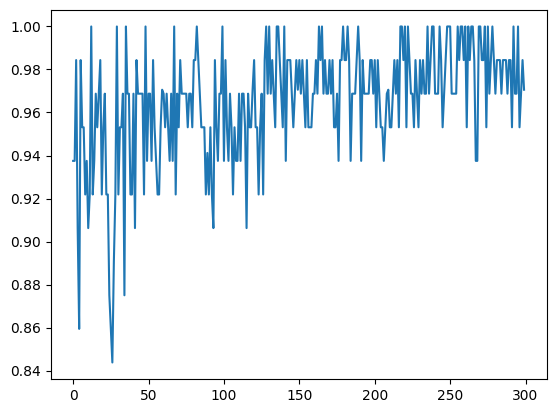

In [10]:
sns.lineplot(
    x=range(len(train_loss_items)),
    y=train_acc_items
)
plt.show()

sns.lineplot(
    x=range(len(val_loss_items)),
    y=val_acc_items
)
plt.show()

In [11]:
test_df = pd.read_csv(args.csv_path['test'])
test_df.sample(5)

,images
4709,./data/eval/images/580ddace198a1cd3918a4f1a6cf...
7588,./data/eval/images/8737dd7c87d041669aaacf65870...
11348,./data/eval/images/078b1df6fb731d4f3fc6d905e17...
4090,./data/eval/images/85f9fdb9d10aca570143fecaba7...
6599,./data/eval/images/762eb4d413db58217cf62b28759...


In [12]:
# inference
test_dataset = CustomDataset(args.root_path['test'],test_df.images.values,labels=None, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [13]:
# load

# model = load_model(model, './models/ckpt/10_best.pth')

model.eval()
preds = []
with torch.no_grad():
    for idx, data in enumerate(tqdm(test_loader)):
        imgs = data['image'].to(device)
        pred = model(imgs)
        pred = pred.argmax(dim=-1)
        preds.extend(pred.cpu().numpy())

# info['ans'] = preds
# save_path = os.path.join(output_dir, f'output.csv')
# info.to_csv(save_path, index=False)
# print(f"Inference Done! Inference result saved at {save_path}")

100%|██████████| 197/197 [00:27<00:00,  7.08it/s]


0


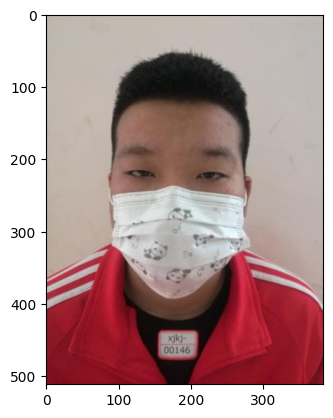

0


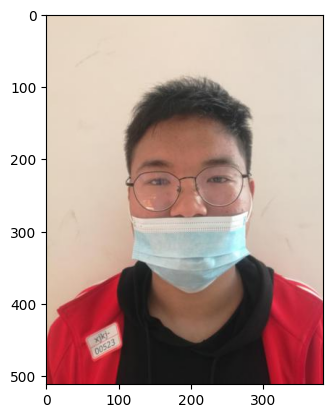

1


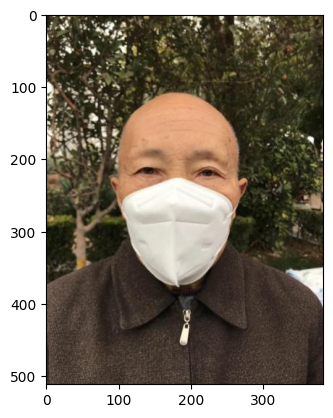

0


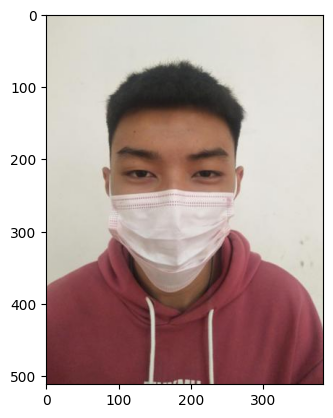

1


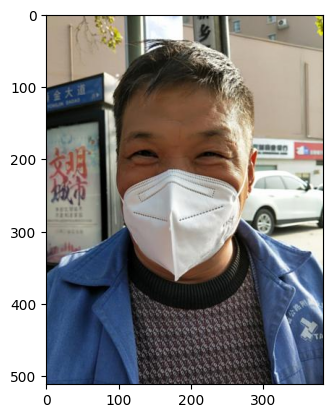

0


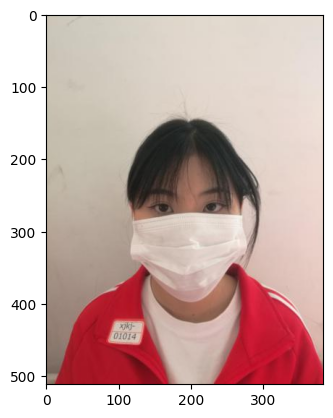

0


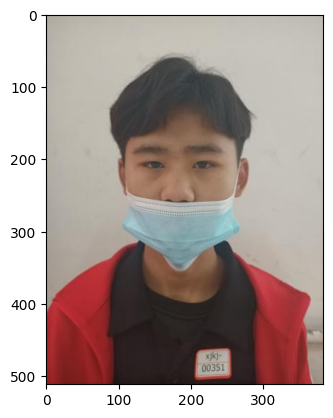

0


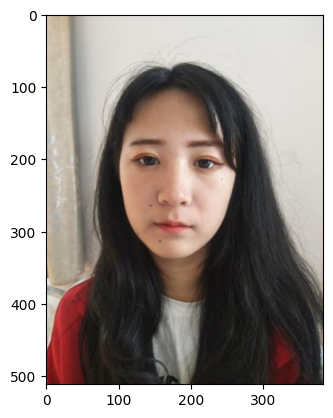

0


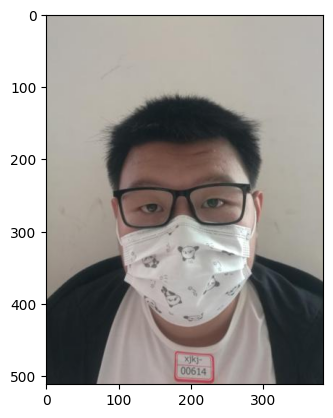

1


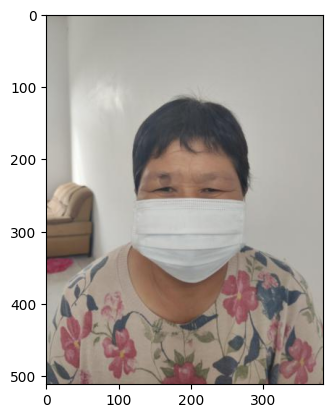

2


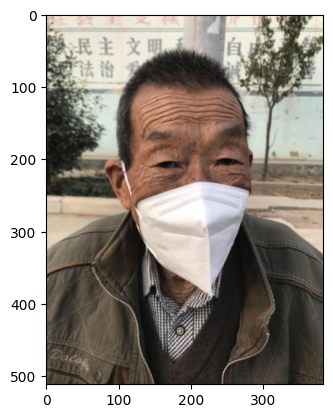

In [14]:
for idx, p in enumerate(test_df.images.values):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(preds[idx])
    plt.imshow(img)
    plt.show()
    if idx == 10:
        break

# 여기서 csv로 바꾸는 작업 필요